In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re

# Load the data
df = pd.read_csv('prosumer_stats.csv')

# Function to parse the transactions string
def parse_transactions(trans_str):
    if pd.isna(trans_str):
        return []
    # Remove 'np.float64(' and corresponding closing ')' to make it standard Python structure
    clean_str = re.sub(r'np\.float64\((.*?)\)', r'\1', trans_str)
    try:
        return ast.literal_eval(clean_str)
    except:
        return []

df['transactions_list'] = df['transactions'].apply(parse_transactions)

# Create a mapping of ID to Neighborhood for later use
id_to_hood = df.set_index('id')['neighbourhood'].to_dict()


df.head()

,hour,id,pv_capacity,battery_capacity,battery_level,imbalance,money_balance,trading_price,neighbourhood,bonus,penalty,p2p_exchanges,agg_exchanges,transactions,transactions_list
0,0,2,1.5,5,0.0,0.0,-21.304073,107.037360,Lingotto,1.0,1.0,0,1,"[{'sender': 'Aggregator', 'receiver': 2, 'amou...","[{'sender': 'Aggregator', 'receiver': 2, 'amou..."
1,0,7,0.0,0,0.0,0.0,-23.084100,107.490093,Lingotto,1.0,1.0,0,1,"[{'sender': 'Aggregator', 'receiver': 7, 'amou...","[{'sender': 'Aggregator', 'receiver': 7, 'amou..."
2,0,10,0.0,10,0.0,0.0,-43.781070,95.646943,Lingotto,1.0,1.0,0,1,"[{'sender': 'Aggregator', 'receiver': 10, 'amo...","[{'sender': 'Aggregator', 'receiver': 10, 'amo..."
3,0,26,4.0,10,0.0,0.0,-40.518992,112.646886,Lingotto,1.0,1.0,0,1,"[{'sender': 'Aggregator', 'receiver': 26, 'amo...","[{'sender': 'Aggregator', 'receiver': 26, 'amo..."
4,0,36,1.5,10,0.0,0.0,-31.053829,100.377150,Lingotto,1.0,1.0,0,1,"[{'sender': 'Aggregator', 'receiver': 36, 'amo...","[{'sender': 'Aggregator', 'receiver': 36, 'amo..."


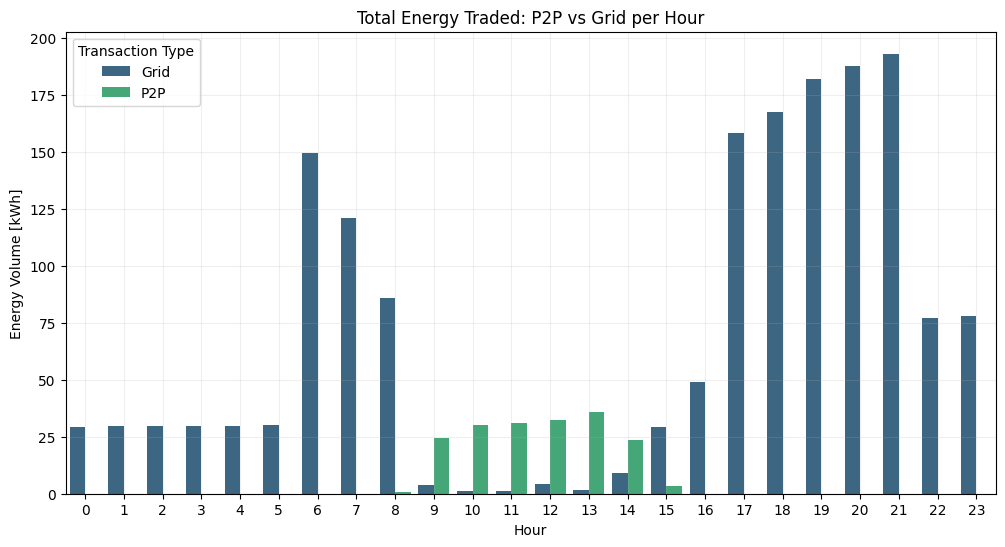

In [20]:
#Energy Flows (Global & Hourly)
#Visualize the total energy volume traded P2P vs. with the Grid/Aggregator per hour

# Aggregate transaction data
hourly_energy = {'hour': [], 'type': [], 'amount': []}

for index, row in df.iterrows():
    for t in row['transactions_list']:
        hourly_energy['hour'].append(t['hour'])
        if t['type'] == 'P2P':
            t_type = 'P2P'
        else:
            t_type = 'Grid'
        hourly_energy['type'].append(t_type)
        hourly_energy['amount'].append(t['amount'])

energy_df = pd.DataFrame(hourly_energy)
energy_summary = energy_df.groupby(['hour', 'type'])['amount'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=energy_summary, x='hour', y='amount', hue='type', palette='viridis')
plt.title('Total Energy Traded: P2P vs Grid per Hour')
plt.xlabel('Hour')
plt.ylabel('Energy Volume [kWh]')
plt.legend(title='Transaction Type')
plt.grid( alpha=0.2)
plt.show()

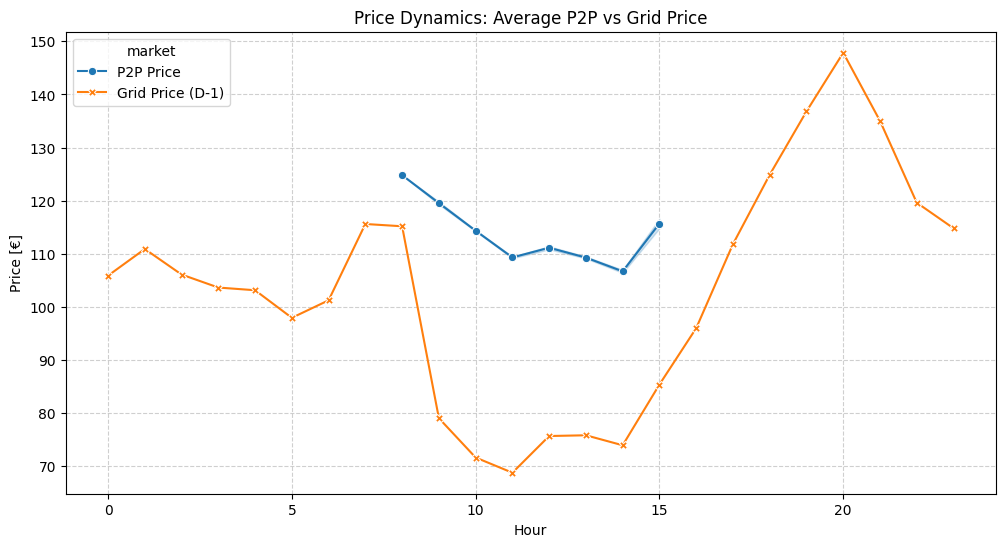

In [21]:
#Price Dynamics
#Compare the average P2P trading price against the Grid (Aggregator) price over time.
price_data = {'hour': [], 'price': [], 'market': []}

# 1. Get P2P Prices from transactions
for index, row in df.iterrows():
    for t in row['transactions_list']:
        if t['type'] == 'P2P':
            price_data['hour'].append(t['hour'])
            price_data['price'].append(t['price_per_kWh'])
            price_data['market'].append('P2P Price')

# 2. Get Grid Prices from the main columns (averaged per hour)
grid_prices = df.groupby('hour')['trading_price'].mean().reset_index()
for _, row in grid_prices.iterrows():
    price_data['hour'].append(row['hour'])
    price_data['price'].append(row['trading_price'])
    price_data['market'].append('Grid Price (D-1)')

price_df = pd.DataFrame(price_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=price_df, x='hour', y='price', hue='market', style='market', markers=True, dashes=False)
plt.title('Price Dynamics: Average P2P vs Grid Price')
plt.xlabel('Hour')
plt.ylabel('Price [€]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

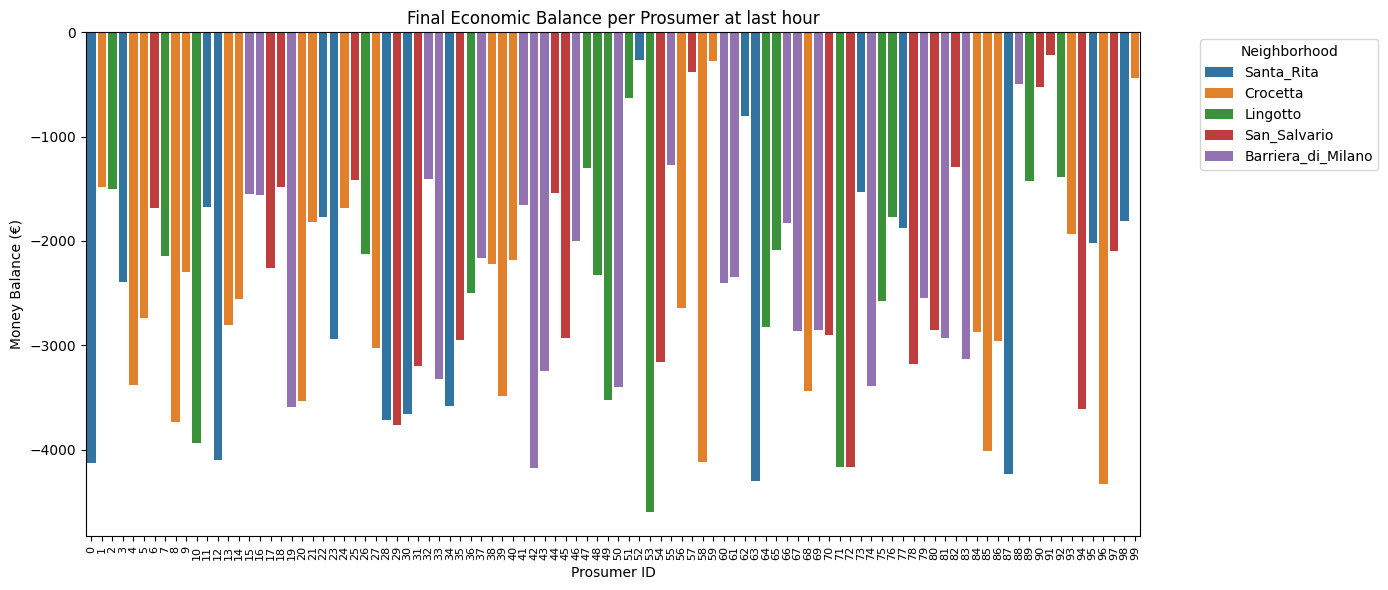

In [22]:
#Prosumer Economic Outcomes
#Show who made money and who lost money by the end of the simulation.

# final state (last hour) for each prosumer
last_hour = df['hour'].max()
final_stats = df[df['hour'] == last_hour].sort_values('money_balance')

plt.figure(figsize=(14, 6))
# color bars by neighborhood
sns.barplot(data=final_stats, x='id', y='money_balance', hue='neighbourhood', dodge=False)
plt.title(f'Final Economic Balance per Prosumer at last hour')
plt.xlabel('Prosumer ID')
plt.ylabel('Money Balance (€)')
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

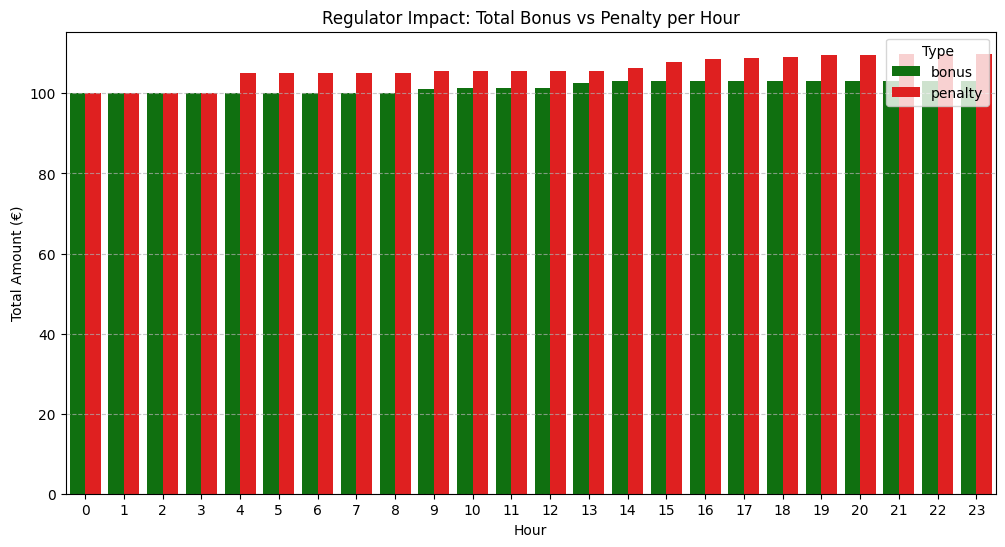

In [23]:
#Regulator Impact (Bonus vs Penalty)
#Visualize the financial incentives applied by the regulator

# Sum bonuses and penalties per hour
regulator_stats = df.groupby('hour')[['bonus', 'penalty']].sum().reset_index()
# Melt for plotting
regulator_melted = regulator_stats.melt('hour', var_name='Type', value_name='Amount')

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=regulator_melted, x='hour', y='Amount', hue='Type', palette=['green', 'red'])
plt.title('Regulator Impact: Total Bonus vs Penalty per Hour')
plt.xlabel('Hour')
plt.ylabel('Total Amount (€)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

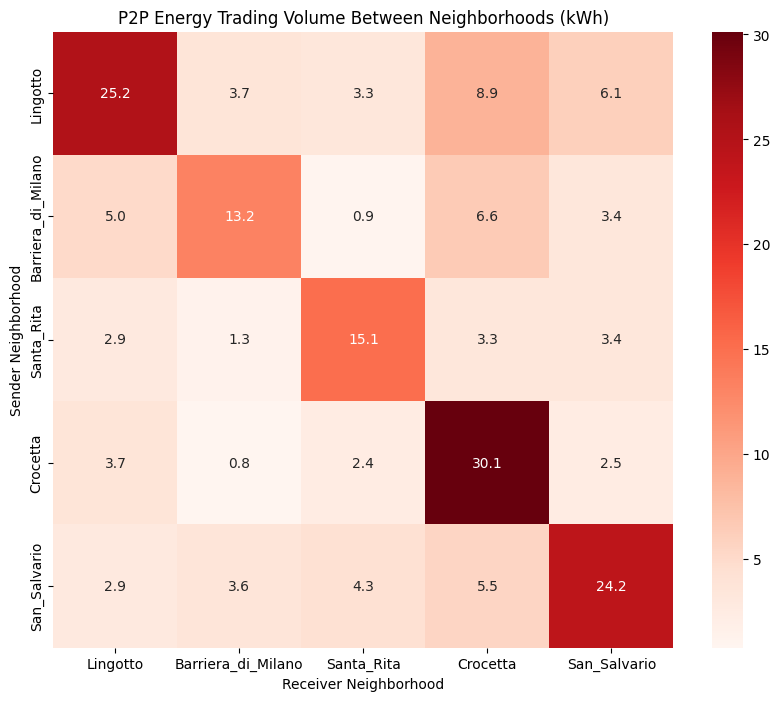

In [24]:
#Neighborhood Trading Heatmap
#See which neighborhoods are trading with each other (P2P)

neighborhoods = df['neighbourhood'].unique()
# Create a square DataFrame initialized with zeros
trade_matrix = pd.DataFrame(0.0, index=neighborhoods, columns=neighborhoods)

# Fill matrix with P2P trade volumes
for index, row in df.iterrows():
    sender_hood = row['neighbourhood']
    transactions = row['transactions_list']
    
    for t in transactions:
        if t['type'] == 'P2P':
            receiver_id = t['receiver']
            amount = t['amount']
            
            # Find receiver's neighborhood
            if receiver_id in id_to_hood:
                receiver_hood = id_to_hood[receiver_id]
                # Add to matrix (Rows = Senders, Cols = Receivers)
                trade_matrix.loc[sender_hood, receiver_hood] += amount

plt.figure(figsize=(10, 8))
sns.heatmap(trade_matrix, annot=True, cmap='Reds', fmt='.1f')
plt.title('P2P Energy Trading Volume Between Neighborhoods (kWh)')
plt.xlabel('Receiver Neighborhood')
plt.ylabel('Sender Neighborhood')
plt.show()